**0) Imports + Utilities**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
np.random.seed(42)

def sigmoid(x):
    return 1/(1 + np.exp(-x))


**1) Simulator (Real-life behavior + fatigue + opt-out)**

In [2]:
@dataclass
class User:
    utype: int
    fatigue: float = 0.0
    active: bool = True
    total_sent: int = 0
    total_clicked: int = 0
    opted_out: bool = False

class NotificationEnv:
    """
    Arms are (time_slot, msg_type).
    Reward is binary click.
    Users can opt out, becoming inactive permanently.
    """

    def __init__(self,
                 n_users=500,
                 time_slots=("9am", "1pm", "6pm", "9pm"),
                 msg_types=("short", "motivational", "detailed"),
                 p_user_types=(0.35, 0.40, 0.25),
                 fatigue_increase=0.25,
                 fatigue_decay=0.06,
                 optout_base=-4.2,
                 optout_fatigue_weight=0.75,
                 noise_std=0.2):

        self.time_slots = list(time_slots)
        self.msg_types = list(msg_types)
        self.arms = [(t, m) for t in self.time_slots for m in self.msg_types]
        self.K = len(self.arms)

        self.fatigue_increase = fatigue_increase
        self.fatigue_decay = fatigue_decay
        self.optout_base = optout_base
        self.optout_fatigue_weight = optout_fatigue_weight
        self.noise_std = noise_std

        # Create users with latent types
        self.users = []
        types = np.random.choice(len(p_user_types), size=n_users, p=p_user_types)
        for ut in types:
            self.users.append(User(utype=int(ut)))

        # Type preferences over time slots (latent, not shown to bandit)
        # Rows=types, Cols=time_slots
        # You can tune these to make the problem harder/easier.
        self.type_time_pref = np.array([
            [ 1.2,  0.2, -0.4, -0.8],  # Type 0: morning lovers
            [-0.2,  0.4,  1.0,  0.2],  # Type 1: evening-ish
            [-0.6,  0.1,  0.3,  1.1],  # Type 2: night owls
        ], dtype=float)

        # Message-type effects (global)
        self.msg_effect = {
            "short": 0.25,
            "motivational": 0.45,
            "detailed": 0.10
        }

        # Base engagement for each type (latent)
        self.type_base = np.array([ -1.0, -0.8, -0.9 ], dtype=float)

    def active_user_indices(self):
        return [i for i, u in enumerate(self.users) if u.active]

    def expected_click_prob(self, user: User, arm_idx: int):
        """Ground-truth expected probability of click given current user state (used for regret)."""
        time_slot, msg = self.arms[arm_idx]
        t_idx = self.time_slots.index(time_slot)

        x = (
            self.type_base[user.utype]
            + self.type_time_pref[user.utype, t_idx]
            + self.msg_effect[msg]
            - 1.25 * user.fatigue
        )
        return float(sigmoid(x))

    def expected_optout_prob(self, user: User):
        """Probability of opting out this step (depends on fatigue)."""
        z = self.optout_base + self.optout_fatigue_weight * user.fatigue
        return float(sigmoid(z))

    def step(self, user_idx: int, arm_idx: int):
        """
        Takes action for a user. Returns:
          reward (0/1),
          opted_out (bool),
          p_click (float),
          p_best (float)
        """
        u = self.users[user_idx]
        if not u.active:
            return 0, False, 0.0, 0.0

        # Fatigue decays every day regardless (modeling "time passes")
        u.fatigue = max(0.0, u.fatigue - self.fatigue_decay)

        # Compute click probabilities + small noise
        p_click = self.expected_click_prob(u, arm_idx)
        p_click_noisy = float(np.clip(p_click + np.random.normal(0, self.noise_std), 0, 1))

        # Oracle best arm probability at current state (for regret)
        p_all = [self.expected_click_prob(u, a) for a in range(self.K)]
        p_best = float(np.max(p_all))

        # Reward sample
        reward = int(np.random.rand() < p_click_noisy)

        # Update user stats
        u.total_sent += 1
        u.total_clicked += reward

        # Sending increases fatigue (even if no click)
        u.fatigue += self.fatigue_increase

        # Opt-out sample (after being notified)
        p_opt = self.expected_optout_prob(u)
        opted_out = bool(np.random.rand() < p_opt)
        if opted_out:
            u.active = False
            u.opted_out = True

        return reward, opted_out, p_click, p_best


**2) Bandit Algorithms (ε-greedy, UCB1, Thompson)**

In [3]:
class EpsilonGreedy:
    def __init__(self, K, eps=0.08):
        self.K = K
        self.eps = eps
        self.n = np.zeros(K, dtype=int)
        self.mean = np.zeros(K, dtype=float)

    def select_arm(self):
        if np.random.rand() < self.eps:
            return np.random.randint(self.K)
        return int(np.argmax(self.mean))

    def update(self, arm, reward):
        self.n[arm] += 1
        self.mean[arm] += (reward - self.mean[arm]) / self.n[arm]


class UCB1:
    def __init__(self, K):
        self.K = K
        self.n = np.zeros(K, dtype=int)
        self.mean = np.zeros(K, dtype=float)
        self.t = 0

    def select_arm(self):
        self.t += 1
        # ensure each arm tried once
        for a in range(self.K):
            if self.n[a] == 0:
                return a
        ucb = self.mean + np.sqrt(2 * np.log(self.t) / self.n)
        return int(np.argmax(ucb))

    def update(self, arm, reward):
        self.n[arm] += 1
        self.mean[arm] += (reward - self.mean[arm]) / self.n[arm]


class ThompsonBetaBernoulli:
    def __init__(self, K, alpha0=1.0, beta0=1.0):
        self.K = K
        self.alpha = np.ones(K, dtype=float) * alpha0
        self.beta = np.ones(K, dtype=float) * beta0

    def select_arm(self):
        samples = np.random.beta(self.alpha, self.beta)
        return int(np.argmax(samples))

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += (1 - reward)


**3) A/B Testing Baseline (Fixed Allocation, non-adaptive)**

In [4]:
def ab_test_proportion(x_a, n_a, x_b, n_b):
    """Two-proportion z-test (approx). Returns z and p-value."""
    if n_a == 0 or n_b == 0:
        return 0.0, 1.0
    p_pool = (x_a + x_b) / (n_a + n_b)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
    if se == 0:
        return 0.0, 1.0
    z = (x_b/n_b - x_a/n_a) / se
    # two-sided p-value via normal approx
    # using erf for normal CDF without scipy
    from math import erf, sqrt
    p = 2 * (1 - 0.5 * (1 + erf(abs(z) / sqrt(2))))
    return float(z), float(p)


**4) Experiment Runner**

In [5]:
def run_policy(env, policy, days=120, daily_users=200):
    rewards = []
    regrets = []
    optouts = []
    active_counts = []

    for day in range(days):
        active = env.active_user_indices()
        active_counts.append(len(active))
        if len(active) == 0:
            break

        chosen = np.random.choice(active, size=min(daily_users, len(active)), replace=False)

        day_reward = 0
        day_regret = 0.0
        day_optout = 0

        for uid in chosen:
            arm = policy.select_arm()
            r, oo, p_click, p_best = env.step(uid, arm)
            policy.update(arm, r)

            day_reward += r
            day_regret += (p_best - p_click)
            day_optout += int(oo)

        rewards.append(day_reward)
        regrets.append(day_regret)
        optouts.append(day_optout)

    return {
        "rewards": np.array(rewards),
        "regrets": np.array(regrets),
        "optouts": np.array(optouts),
        "active_counts": np.array(active_counts[:len(rewards)])
    }


def run_ab(env, arm_A, arm_B, days=120, daily_users=200, split=0.5):
    rewards = []
    regrets = []
    optouts = []
    active_counts = []

    # stats for test
    clicks_A = 0; n_A = 0
    clicks_B = 0; n_B = 0

    for day in range(days):
        active = env.active_user_indices()
        active_counts.append(len(active))
        if len(active) == 0:
            break

        chosen = np.random.choice(active, size=min(daily_users, len(active)), replace=False)
        group = (np.random.rand(len(chosen)) < split)  # True -> A

        day_reward = 0
        day_regret = 0.0
        day_optout = 0

        for uid, is_A in zip(chosen, group):
            arm = arm_A if is_A else arm_B
            r, oo, p_click, p_best = env.step(uid, arm)

            day_reward += r
            day_regret += (p_best - p_click)
            day_optout += int(oo)

            if is_A:
                clicks_A += r; n_A += 1
            else:
                clicks_B += r; n_B += 1

        rewards.append(day_reward)
        regrets.append(day_regret)
        optouts.append(day_optout)

    z, p = ab_test_proportion(clicks_A, n_A, clicks_B, n_B)

    return {
        "rewards": np.array(rewards),
        "regrets": np.array(regrets),
        "optouts": np.array(optouts),
        "active_counts": np.array(active_counts[:len(rewards)]),
        "ab_stats": {"clicks_A": clicks_A, "n_A": n_A, "clicks_B": clicks_B, "n_B": n_B, "z": z, "p": p}
    }


**5) Run Everything + Plot Results**

A/B stats: {'clicks_A': 1210, 'n_A': 5542, 'clicks_B': 1086, 'n_B': 5784, 'z': -4.045754656795176, 'p': 5.215483415255129e-05}


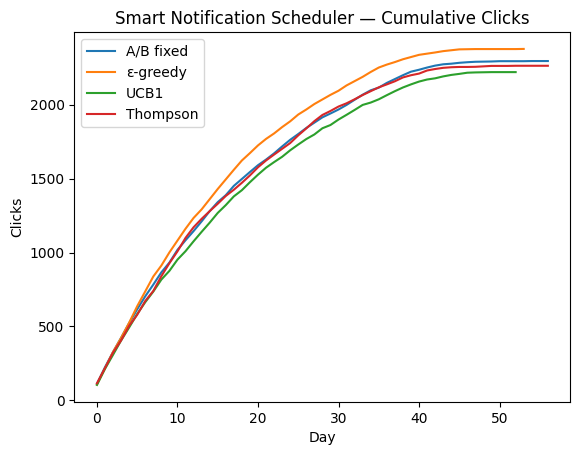

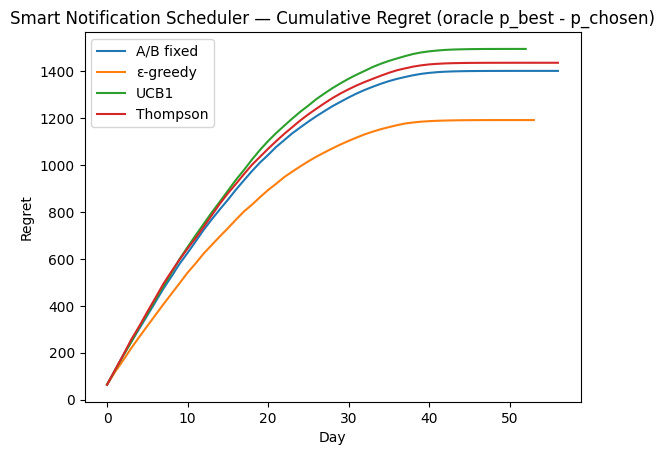

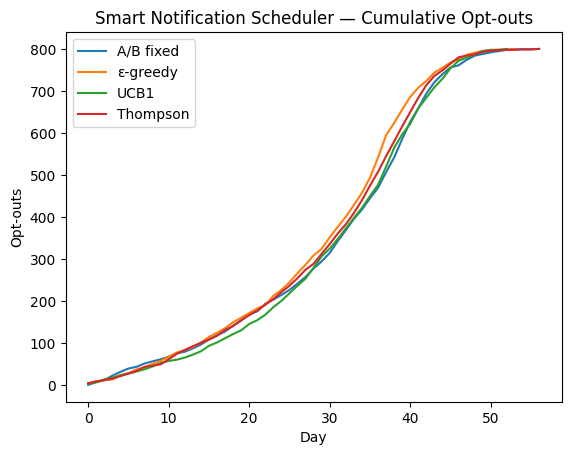

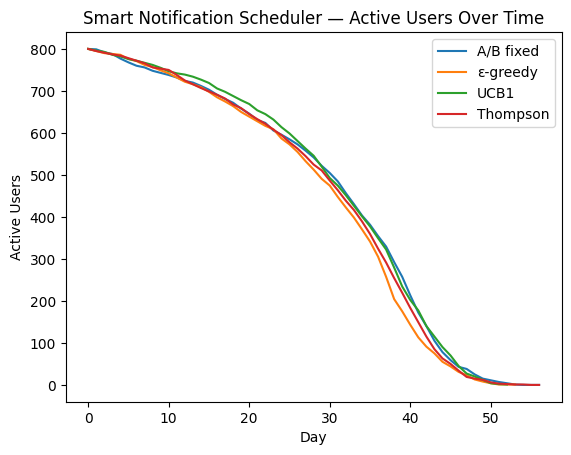

In [6]:
def arm_index(env, time_slot, msg_type):
    return env.arms.index((time_slot, msg_type))

def plot_results(results_dict, title_prefix=""):
    plt.figure()
    for name, res in results_dict.items():
        plt.plot(np.cumsum(res["rewards"]), label=name)
    plt.title(f"{title_prefix}Cumulative Clicks")
    plt.xlabel("Day")
    plt.ylabel("Clicks")
    plt.legend()
    plt.show()

    plt.figure()
    for name, res in results_dict.items():
        plt.plot(np.cumsum(res["regrets"]), label=name)
    plt.title(f"{title_prefix}Cumulative Regret (oracle p_best - p_chosen)")
    plt.xlabel("Day")
    plt.ylabel("Regret")
    plt.legend()
    plt.show()

    plt.figure()
    for name, res in results_dict.items():
        plt.plot(np.cumsum(res["optouts"]), label=name)
    plt.title(f"{title_prefix}Cumulative Opt-outs")
    plt.xlabel("Day")
    plt.ylabel("Opt-outs")
    plt.legend()
    plt.show()

    plt.figure()
    for name, res in results_dict.items():
        plt.plot(res["active_counts"], label=name)
    plt.title(f"{title_prefix}Active Users Over Time")
    plt.xlabel("Day")
    plt.ylabel("Active Users")
    plt.legend()
    plt.show()


# ---- Run the experiment ----
env_base = NotificationEnv(n_users=800)

# Choose two A/B policies (fixed)
arm_A = arm_index(env_base, "6pm", "motivational")
arm_B = arm_index(env_base, "9pm", "short")

# Separate env copies so comparisons are fair
def clone_env(env):
    new_env = NotificationEnv(
        n_users=0,
        time_slots=env.time_slots,
        msg_types=env.msg_types,
        fatigue_increase=env.fatigue_increase,
        fatigue_decay=env.fatigue_decay,
        optout_base=env.optout_base,
        optout_fatigue_weight=env.optout_fatigue_weight,
        noise_std=env.noise_std
    )
    new_env.users = [User(u.utype, fatigue=0.0, active=True) for u in env.users]
    new_env.type_time_pref = env.type_time_pref.copy()
    new_env.msg_effect = dict(env.msg_effect)
    new_env.type_base = env.type_base.copy()
    return new_env

# A/B
env_ab = clone_env(env_base)
res_ab = run_ab(env_ab, arm_A, arm_B, days=140, daily_users=260, split=0.5)

# Bandits
env_eps = clone_env(env_base)
env_ucb = clone_env(env_base)
env_ts  = clone_env(env_base)

res_eps = run_policy(env_eps, EpsilonGreedy(env_eps.K, eps=0.08), days=140, daily_users=260)
res_ucb = run_policy(env_ucb, UCB1(env_ucb.K), days=140, daily_users=260)
res_ts  = run_policy(env_ts,  ThompsonBetaBernoulli(env_ts.K, alpha0=1, beta0=1), days=140, daily_users=260)

results = {
    "A/B fixed": res_ab,
    "ε-greedy": res_eps,
    "UCB1": res_ucb,
    "Thompson": res_ts
}

print("A/B stats:", res_ab["ab_stats"])
plot_results(results, title_prefix="Smart Notification Scheduler — ")
